<a href="https://colab.research.google.com/github/ssk1177/Predictive-Analytics/blob/main/Titanic_passengers_Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Readme:**

The objective is to evaluate tree-based ensemble models including random forest, gradient boosted and adaboost classifiers using the cleaned and preprocessed version of the Titanic dataset

**Dataset:**

**Titanic**: The original Titanic dataset, describing the survival status of individual passengers on the Titanic

https://openml.org/search?type=data&status=active&id=40945&sort=runs


# Table of contents <a class="anchor" id="toc"></a>
* [Load the Packages](#load_packages)
* [Functional Blocks](#functional_blocks)
* [Load the Dataset](#load_dataset)
* [Explore the dataset](#explore_dataset)
* [Preprocessing](#preprocessing)
    * [Missing values](#missing_values)
    * [Drop the irrelevant features](#drop_irrelevant)
    * [Replace missing values](#replace_missing)
    * [Feature Encoding](#feature_encoding)
* [Feature Selection](#feature_selection)
* [Feature Engineering](#feature_engineering)
    * [Binning](#binning)
* [Pipeline](#pipeline)
* [Data split: Train and Test sets](#data_split)
* [Modelling](#modelling)
    * [Decision Tree](#decision_tree)
        * [Classifier Pipeline](#dt_classifier_pipeline)
        * [Feature Importance](#feature_importance)
        * [Metrics](#dt_metrics)
            * [Classification Report](#dt_classification_report)
            * [Confusion Matrix](#dt_confusion_matrix)
        * [Tree Structure](#tree_structure)
        * [Tree Pruning](#tree_pruning)
            * [Retrain with Tree Pruning](#retrain_with_pruning)
            * [Metrics](#rp_metrics)
                * [Classification Report](#rp_classification_report)
                * [Confusion Matrix](#rp_confusion_matrix)
                * [Feature Importance](#rp_feature_imp)
        * [Hyper-parameters Tuning](#hyper_params_tuning)
            * [Retrain with Hyper-parameters Tuned](#hp_tuned_retrain)
            * [Metrics](#hp_tuned_metrics)
                * [Comfusion Matrix](#hp_confusion_matrix)
    * [Random Forest](#random_forest)
        * [Metrics](#rf_metrics)
            * [Classification Report](#rf_classification_report)
            * [Confusion Matrix](#rf_confusion_matrix)
        * [Feature Importance](#rf_feature_imp)
    * [Gradient Boosting](#gradiet_boosting)
        * [Metrics](#gb_metrics)
            * [Classification Report](#gb_classification_report)
            * [Confusion Matrix](#gb_confusion_matrix)
        * [Feature Importance](#gb_feature_importance)
    * [AdaBoost](#AdaBoost)
        * [Metrics](#AB_metrics)
            * [Classification Report](#AB_classification_report)
            * [Confusion Matrix](#AB_confusion_matrix)
        * [Feature Importance](#AB_feature_importance)
                

## Load the Packages <a class="anchor" id="load_packages"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import time

# sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.tree import plot_tree, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree, set_config, metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from IPython.display import HTML, display, Markdown as md, Latex
from ipywidgets import widgets, Layout
from ipywidgets import Output, Tab
from matplotlib import pyplot as plt

# check scikit-learn version
from sklearn import __version__ as ver
print(f"scikit-learn version: {ver}")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

scikit-learn version: 1.3.0


## Functional Blocks <a class="anchor" id="functional_blocks"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
def feat_imp_chart(feat_imp, feat_names, plot_head):
    importances = pd.Series(feat_imp, index=feat_names).sort_values(ascending=True)
    importances.plot.barh()
    plt.title(plot_head)
    plt.show()

def get_top_5(data):
    return np.sort(data)[::-1][0:5]

## Load the Titanic Dataset (Source: openml.org) <a class="anchor" id="load_dataset"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

## Explore the dataset <a class="anchor" id="explore_dataset"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
dtypes: category(2), float64(6), object(5)
memory usage: 115.4+ KB


### Observations
- Features 'cabin', 'boat', 'body', and 'home.dest' has very few non-null values.
- Feature 'sex' and 'embarked' are of type category and would require encoding (?)

In [ ]:
X.describe()

,pclass,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000


### Observations
- Features such as 'age', 'fare' and 'body' are of different ranges than 'pclass' and 'sibsp' and 'parch', might require scaling.

In [ ]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1309 entries, 0 to 1308
Series name: survived
Non-Null Count  Dtype   
--------------  -----   
1309 non-null   category
dtypes: category(1)
memory usage: 1.5 KB


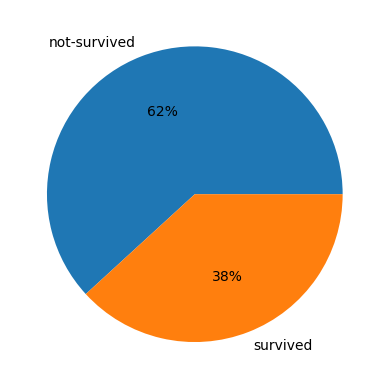

In [ ]:
plt.pie (y.value_counts(), labels=['not-survived', 'survived'], autopct='%1.0f%%')
plt.show()

## Preprocessing <a class="anchor" id="preprocessing"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

### Missing values <a class="anchor" id="missing_values"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# Check for missing values
X.isnull().any()

pclass       False
name         False
sex          False
age           True
sibsp        False
parch        False
ticket       False
fare          True
cabin         True
embarked      True
boat          True
body          True
home.dest     True
dtype: bool

In [ ]:
# Check how much percentage of missing values in feature
X.isnull().sum() / len(X) * 100

pclass        0.000000
name          0.000000
sex           0.000000
age          20.091673
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.076394
cabin        77.463713
embarked      0.152788
boat         62.872422
body         90.756303
home.dest    43.086325
dtype: float64

In [ ]:
# Get the data types of features
X.dtypes

pclass        float64
name           object
sex          category
age           float64
sibsp         float64
parch         float64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

### Observations
1. Features 'body', 'boat' and 'cabin' has more than 60% missing values, so we can drop these features (though the more research is needed to verify whether it's ideal to remove or fill the concerned features, but for simplicity sake for this lab, I am removing it)
2. Features 'age', 'fare' and 'embarked' has the null/missing values, but features 'age' and 'fare' are of numerical type so will replace the values using median while 'embarked' is categorical type, hence it makes more sense to replace it with the mode value.
3. Replacing the feature 'home.dest' (which represents the address) doesn't make much sense, so for simplicity of the model, removing this feature.
4. Feature 'ticket' is not relevant to the objective of our report, so removing it.

### Drop the irrelevant features <a class="anchor" id="drop_irrelevant"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# On basis of the above observations, dropping following irrelevant features
X.drop(["cabin", "boat", "body", "home.dest", "ticket"], axis=1, inplace=True)
X.head()

,pclass,name,sex,age,sibsp,parch,fare,embarked
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,211.3375,S
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,151.5500,S
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,151.5500,S
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,151.5500,S
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,151.5500,S


### Replace missing values <a class="anchor" id="replace_missing"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# Replacing missing values
X["age"].fillna(X["age"].median(), inplace=True)
X["fare"].fillna(X["fare"].median(), inplace=True)
X["embarked"].fillna(X["embarked"].mode()[0], inplace=True)

# Verify whether any missing value in any feature
X.isnull().any()

pclass      False
name        False
sex         False
age         False
sibsp       False
parch       False
fare        False
embarked    False
dtype: bool

### Feature Encoding <a class="anchor" id="feature_encoding"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>
Convert categorical features to numerical

In [ ]:
le = LabelEncoder()
X["sex"] = le.fit_transform(X["sex"])
X["embarked"] = le.fit_transform(X["embarked"])

# Verify the dataset
X.head()

,pclass,name,sex,age,sibsp,parch,fare,embarked
0,1.0,"Allen, Miss. Elisabeth Walton",0,29.0000,0.0,0.0,211.3375,2
1,1.0,"Allison, Master. Hudson Trevor",1,0.9167,1.0,2.0,151.5500,2
2,1.0,"Allison, Miss. Helen Loraine",0,2.0000,1.0,2.0,151.5500,2
3,1.0,"Allison, Mr. Hudson Joshua Creighton",1,30.0000,1.0,2.0,151.5500,2
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,25.0000,1.0,2.0,151.5500,2


## Feature Selection <a class="anchor" id="feature_selection"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>
Examine Feature Correlations

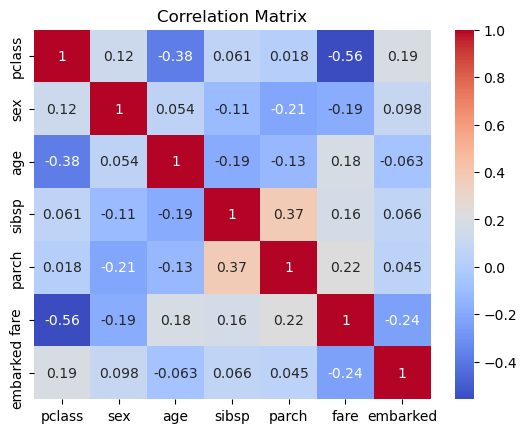

In [ ]:
# Since for correlation we need only numerical values, so
sns.heatmap(X[["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Observation:
Features 'parch' and 'sibsp' are weekly correlated featues, so we can combine them to get the more meaningful information, which lead to feature engineering.

## Feature Engineering <a class="anchor" id="feature_engineering"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# Combining 'parch' and 'sibsp' to create new feature named as 'family_size'

X['family_size'] = X['parch'] + X['sibsp']
X.drop(['parch', 'sibsp'], axis=1, inplace=True)

# Create a derived feature called 'is_alone' using the family_size feature
X['is_alone'] = 1
X['is_alone'].loc[X['family_size'] > 1] = 0

# Print the head to verify the data
X.head()

,pclass,name,sex,age,fare,embarked,family_size,is_alone
0,1.0,"Allen, Miss. Elisabeth Walton",0,29.0000,211.3375,2,0.0,1
1,1.0,"Allison, Master. Hudson Trevor",1,0.9167,151.5500,2,3.0,0
2,1.0,"Allison, Miss. Helen Loraine",0,2.0000,151.5500,2,3.0,0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",1,30.0000,151.5500,2,3.0,0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,25.0000,151.5500,2,3.0,0


In [ ]:
# Using 'name' feature we can derive a new fearture called 'Title' which
# will have values such as 'Mr.' and 'Mrs', 'Cpt.' and 'Dr.',
# these values seems be of interest for our model

# Create new feature
X['title'] =  X['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

# Remove the 'name' feature
X.drop(["name"], axis=1, inplace=True)

# Print the head to verify the data
X.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,title
0,1.0,0,29.0000,211.3375,2,0.0,1,Miss
1,1.0,1,0.9167,151.5500,2,3.0,0,Master
2,1.0,0,2.0000,151.5500,2,3.0,0,Miss
3,1.0,1,30.0000,151.5500,2,3.0,0,Mr
4,1.0,0,25.0000,151.5500,2,3.0,0,Mrs


In [ ]:
# Verify the new feature 'title'
pd.crosstab(X['title'], X['sex'])

sex,0,1
title,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,61


### Observation
It seems like there are so many titles, so we can perform binning or grouping.

### Binning <a class="anchor" id="binning"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# Mark the 'title' as 'rare' if the value is less than 10
rare_titles = (X['title'].value_counts() < 10)
rare_titles

X.title.loc[X.title == 'Miss'] = 'Mrs'
X['title'] = X.title.apply(lambda x: 'rare' if rare_titles[x] else x)

# Verify the new feature 'title'
pd.crosstab(X['title'], X['sex'])

sex,0,1
title,,
Master,0,61
Mr,0,757
Mrs,457,0
rare,9,25


## Pipeline <a class="anchor" id="pipeline"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>
Create preprocessing (numerical, categorical transform) pipeline

In [ ]:
# here we call the new API set_config to tell sklearn we want to output a pandas DF
set_config(transform_output="pandas")

num_features = ['age', 'fare', 'family_size']
cat_features = ['embarked', 'sex', 'pclass', 'title', 'is_alone']

# creating the numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

#creating the transform to preprocess the data
transformer = ColumnTransformer(
    (
        ('numerical', num_pipe, num_features),
        ("categorical",
             OneHotEncoder(sparse_output=False,
                           drop="if_binary",
                           handle_unknown="ignore"),
             cat_features
        )
    ),
    verbose_feature_names_out=False,
)

## Data split: Train and Test sets <a class="anchor" id="data_split"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# split the data for training and testing the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=117)

## Modelling <a class="anchor" id="modelling"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>
Following Algorithms would be trained and compared:
- Decision Tree Classifier
- Random Forest,
- Gradient Boosted and
- Adaboost

### Decision Tree <a class="anchor" id="decision_tree"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

### Classifier Pipeline <a class="anchor" id="dt_classifier_pipeline"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>
Create classifer pipeline with a data preprocessing step and decision tree classifier

In [ ]:
# creating the classifier pipeline with a data preprocessing step and decision tree classifier
rf_pipeline = Pipeline([
    ('dataprep', transformer),
    ('rf_clf', DecisionTreeClassifier(random_state=117))
])

In [ ]:
# training the model
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('dataprep',
                 ColumnTransformer(transformers=(('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare',
                                                   'family_size']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['embarked', 'sex', 'pclass',
                                                   'title', 'is_alone'])),
                                   verbose_feature_names_out=False)),
                ('rf_clf', DecisionTreeClassifier(random_state=117))])

### Feature Importance <a class="anchor" id="feature_importance"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# retrieving the RF Classifier from the model pipeline
clf = rf_pipeline[-1]

print(clf.feature_names_in_)
clf.feature_names_in_[clf.feature_names_in_ == 'sex_1'] = 'sex'

# making a pandas dataframe
data = list(zip(clf.feature_names_in_, clf.feature_importances_))
df_importances = pd.DataFrame(data,
                              columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

df_importances

['age' 'fare' 'family_size' 'embarked_0' 'embarked_1' 'embarked_2' 'sex_1'
 'pclass_1.0' 'pclass_2.0' 'pclass_3.0' 'title_Master' 'title_Mr'
 'title_Mrs' 'title_rare' 'is_alone_1']


,Feature,Importance
11,title_Mr,0.293414
1,fare,0.261285
0,age,0.255944
9,pclass_3.0,0.078000
2,family_size,0.022597
13,title_rare,0.019619
5,embarked_2,0.019072
7,pclass_1.0,0.014560
6,sex,0.009986
14,is_alone_1,0.007210


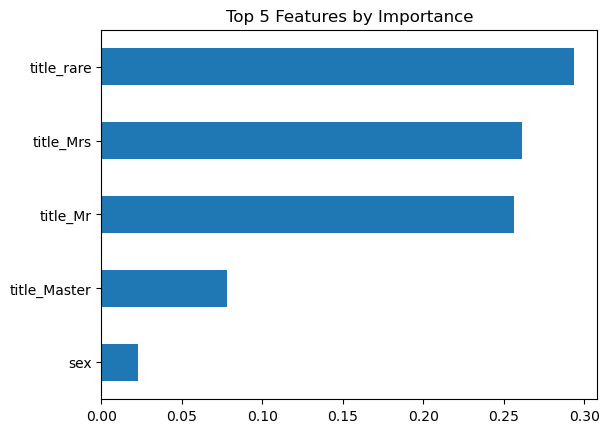

In [ ]:
# Plot feature importance chart
feat_imp_chart(get_top_5(clf.feature_importances_), get_top_5(clf.feature_names_in_), 'Top 5 Features by Importance')
clf_before_prune = clf

### Metrics <a class="anchor" id="dt_metrics"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
X_preproc = rf_pipeline[:-1].transform(X_train)
X_test_preproc = rf_pipeline[:-1].transform(X_test)

X_preproc.rename({'sex_1':'sex'}, axis=1, inplace=True)
X_test_preproc.rename({'sex_1':'sex'}, axis=1, inplace=True)

print(f"Train accuracy: {clf.score(X_preproc, y_train):.3f}")
print(f"Test accuracy: {clf.score(X_test_preproc, y_test):.3f}")

Train accuracy: 0.977
Test accuracy: 0.789


### Observation
Since the Train accuracy is much higher than the Test accuracy, it seems the model overfits the titanic dataset, we can further verify this using cross-validation.

#### Classification Report <a class="anchor" id="dt_classification_report"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
cf_test_start_time = time.time()
yhat = clf.predict(X_test_preproc)
cf_test_end_time = time.time()

print("Test time:", round(cf_test_end_time - cf_test_start_time, 4), "secs\n\n")

print(classification_report(y_test, yhat))

Test time: 0.0016 secs


              precision    recall  f1-score   support

           0       0.81      0.86      0.83       243
           1       0.74      0.68      0.71       150

    accuracy                           0.79       393
   macro avg       0.78      0.77      0.77       393
weighted avg       0.79      0.79      0.79       393



#### Confusion Matrix <a class="anchor" id="dt_confusion_matrix"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

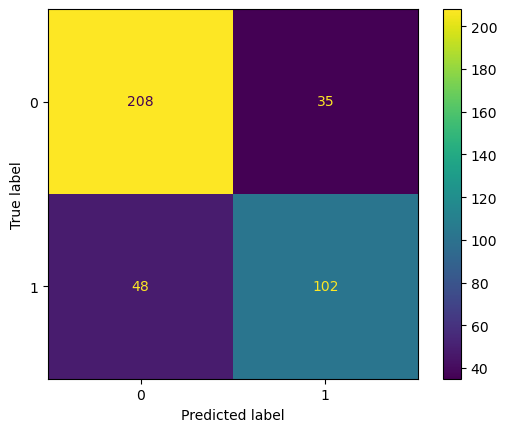

In [ ]:
cm = confusion_matrix(y_test, yhat)
cm_display = ConfusionMatrixDisplay(cm).plot()

#### Tree Structure <a class="anchor" id="tree_structure"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

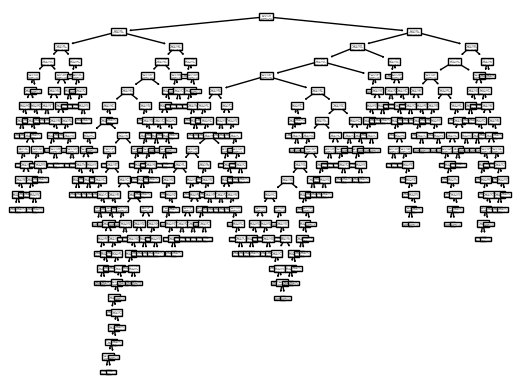

Decision Tree Depth: 24
Decision Tree Node Count: 483


In [ ]:
plot_tree(clf)
plt.show()
print(f"Decision Tree Depth: {clf.get_depth()}")
print(f"Decision Tree Node Count: {clf.tree_.node_count}")

### Tree Pruning <a class="anchor" id="tree_pruning"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1304406291254539


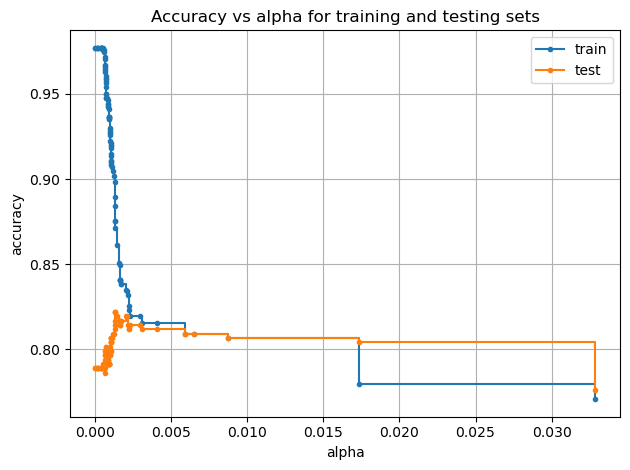

In [ ]:
path = clf.cost_complexity_pruning_path(X_preproc,
                                        y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Wee train a decision tree using the effective alphas. The last value
# in ``ccp_alphas`` is the alpha value that prunes the whole tree,
# leaving the tree, ``clfs[-1]``, with one node.
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=117, ccp_alpha=ccp_alpha)
    clf.fit(X_preproc,
            y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

# We remove the last element in ``clfs`` and ``ccp_alphas``,
# because it is the trivial tree with only one node.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Accuracy vs alpha for training and testing sets
train_scores = [clf.score(X_preproc,
                          y_train) for clf in clfs]
test_scores = [clf.score(X_test_preproc,
                         y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='.', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='.', label="test", drawstyle="steps-post")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

#### Retrain with Pruning <a class="anchor" id="retrain_with_pruning"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
clf_after_prune = DecisionTreeClassifier(random_state=117, ccp_alpha=0.01)

cfp_train_start_time = time.time()
clf_after_prune.fit(X_preproc, y_train)
cfp_train_end_time = time.time()

print("Training time:", round(cfp_train_end_time-cfp_train_start_time, 4), "secs")

print(f"Train accuracy: {clf_after_prune.score(X_preproc, y_train):.3f}")
print(f"Test accuracy: {clf_after_prune.score(X_test_preproc, y_test):.3f}")

Training time: 0.0054 secs
Train accuracy: 0.807
Test accuracy: 0.807


### Metrics <a class="anchor" id="rp_metrics"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
print(f"Decision Tree Depth: {clf_after_prune.get_depth()}")
print(f"Decision Tree Node Count: {clf_after_prune.tree_.node_count}")

Decision Tree Depth: 3
Decision Tree Node Count: 7


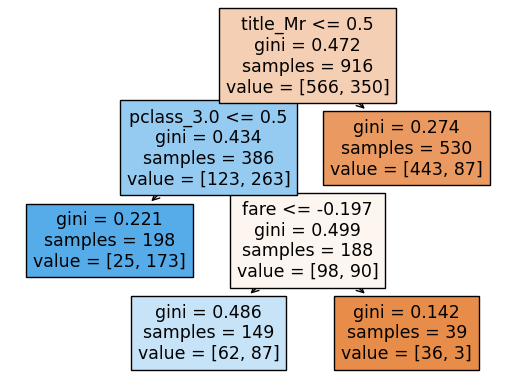

In [ ]:
plot_tree(clf_after_prune, feature_names=list(clf_after_prune.feature_names_in_), filled=True)
plt.show()

#### Classification Report <a class="anchor" id="rp_classification_report"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
cfp_test_start_time = time.time()
yhat_after_prune = clf.predict(X_test_preproc)
cfp_test_end_time = time.time()

print("Testing time:", round(cfp_test_end_time-cfp_test_start_time, 4), "secs\n\n")

print(classification_report(y_test, yhat_after_prune))

Testing time: 0.0007 secs


              precision    recall  f1-score   support

           0       0.62      1.00      0.76       243
           1       0.00      0.00      0.00       150

    accuracy                           0.62       393
   macro avg       0.31      0.50      0.38       393
weighted avg       0.38      0.62      0.47       393



#### Confusion Matrix <a class="anchor" id="rp_confusion_matrix"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

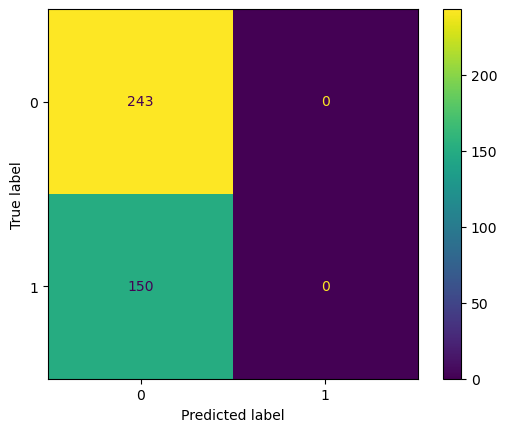

In [ ]:
cm = confusion_matrix(y_test, yhat_after_prune)
cm_display = ConfusionMatrixDisplay(cm).plot()

#### Feature Importance <a class="anchor" id="rp_feature_imp"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

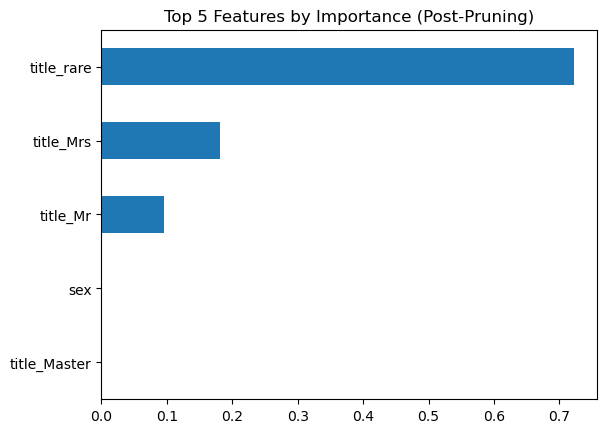

In [ ]:
# Plot feature importance chart
feat_imp_chart(get_top_5(clf_after_prune.feature_importances_),
               get_top_5(clf_after_prune.feature_names_in_),
               'Top 5 Features by Importance (Post-Pruning)')

### Hyper-parameters tuning <a class="anchor" id="hyper_params_tuning"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# List of hyper-parameters supported by decision tree
# 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes',
# 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf',
# 'random_state', 'splitter'

dtree_reg = DecisionTreeRegressor(random_state=123) # Initialize a decision tree regressor

# Define the parameter grid to tune the hyperparameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10,12, 20, 30, None],
    'min_samples_split': np.arange(1, 10, 1),
    'min_samples_leaf': np.arange(1, 10, 1),
    'splitter':["best","random"]
}

clf_GS = GridSearchCV(rf_pipeline[-1], param_grid)
clf_GS.fit(X_preproc, y_train)

best_dtree_reg = clf_GS.best_estimator_ # Get the best estimator from the grid search

y_pred = best_dtree_reg.predict(X_test_preproc)

print('Best Criterion:', clf_GS.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['max_depth'])
print('Min samples split:', clf_GS.best_estimator_.get_params()['min_samples_split'])
print('Min samples leaf:', clf_GS.best_estimator_.get_params()['min_samples_leaf'])
print('Best splitter:', clf_GS.best_estimator_.get_params()['splitter'])

print(f"\nBest score:", clf_GS.best_score_)

Best Criterion: gini
Best max_depth: 10
Min samples split: 8
Min samples leaf: 2
Best splitter: random

Best score: 0.8056901876930386


### Retrain with Hyper-parameters Tuned <a class="anchor" id="hp_tuned_retrain"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
tuned_hyper_model = DecisionTreeClassifier(
                       criterion=str(clf_GS.best_estimator_.get_params()['criterion']),
                       max_depth=clf_GS.best_estimator_.get_params()['max_depth'],
                       min_samples_leaf=clf_GS.best_estimator_.get_params()['min_samples_leaf'],
                       min_samples_split=clf_GS.best_estimator_.get_params()['min_samples_split'],
                       splitter=str(clf_GS.best_estimator_.get_params()['splitter']),
                       random_state=123)

In [ ]:
# fitting model
tuned_hyper_model.fit(X_preproc, y_train)

# prediction
tuned_pred=tuned_hyper_model.predict(X_test_preproc)

#### Metrics <a class="anchor" id="hp_tuned_metrics"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

#### Comfusion Matrix <a class="anchor" id="hp_confusion_matrix"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

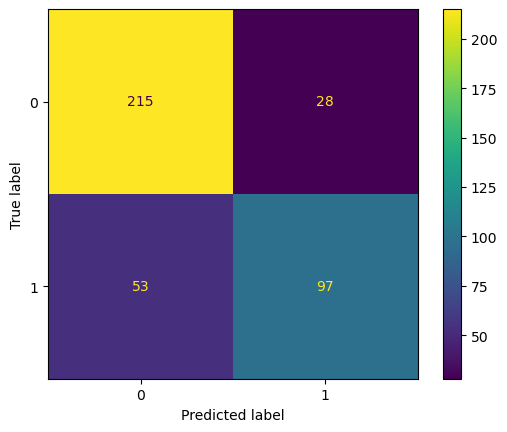

In [ ]:
# Plot Confusion Matrix after model hyper parameters tuning
ConfusionMatrixDisplay(confusion_matrix(y_test, tuned_pred)).plot()

## Random Forest <a class="anchor" id="random_forest"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# Build the Random Forest model
rf = RandomForestClassifier(random_state=117)

rf_train_start_time = time.time()

rf.fit(X_preproc, y_train)

rf_train_end_time = time.time()

print("Training time:", round(rf_train_end_time - rf_train_start_time, 4), "secs")

print(f"Train accuracy: {rf.score(X_preproc, y_train):.3f}")
print(f"Test accuracy: {rf.score(X_test_preproc, y_test):.3f}")

Training time: 0.0748 secs
Train accuracy: 0.977
Test accuracy: 0.779


### Metrics <a class="anchor" id="rf_metrics"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

#### Classification Report <a class="anchor" id="rf_classification_report"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
rf_test_start_time = time.time()

yhat = rf.predict(X_test_preproc)

rf_test_end_time = time.time()

print("Testing time:", round(rf_test_end_time - rf_test_start_time, 4), "secs\n\n")

print(classification_report(y_test, yhat))

Testing time: 0.0094 secs


              precision    recall  f1-score   support

           0       0.81      0.84      0.82       243
           1       0.73      0.67      0.70       150

    accuracy                           0.78       393
   macro avg       0.77      0.76      0.76       393
weighted avg       0.78      0.78      0.78       393



#### Confusion Matrix <a class="anchor" id="rf_confusion_matrix"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

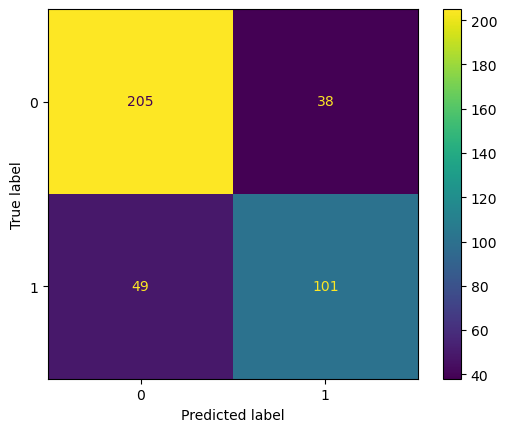

In [ ]:
cm = confusion_matrix(y_test, yhat)
cm_display = ConfusionMatrixDisplay(cm).plot()

### Feature Importance <a class="anchor" id="rf_feature_imp"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

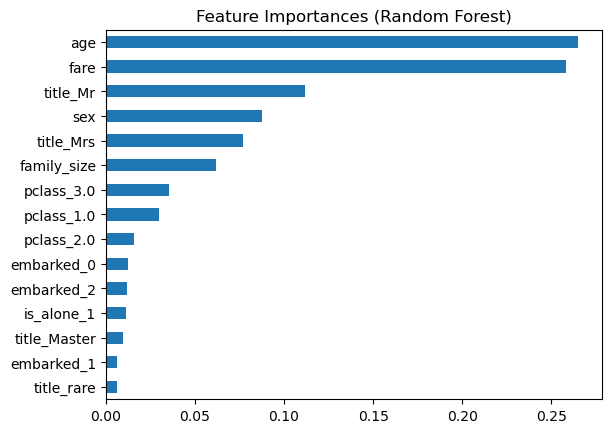

In [ ]:
# feature importances
importances = pd.Series(
    rf.feature_importances_, index=X_preproc.columns
).sort_values(ascending=True).plot.barh()
plt.title('Feature Importances (Random Forest)')
plt.show()

### Gradient Boosting <a class="anchor" id="gradiet_boosting"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# Build the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=117)

gb_train_start_time = time.time()

gb.fit(X_preproc, y_train)

gb_train_end_time = time.time()

print("Training time:", round(gb_train_end_time-gb_train_start_time, 4), "secs")

print(f"Train accuracy: {gb.score(X_preproc, y_train):.3f}")
print(f"Test accuracy: {gb.score(X_test_preproc, y_test):.3f}")

Training time: 0.0683 secs
Train accuracy: 0.873
Test accuracy: 0.817


### Metrics <a class="anchor" id="gb_metrics"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

### Classification Report <a class="anchor" id="gb_classification_report"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
gb_test_start_time = time.time()

yhat = gb.predict(X_test_preproc)

gb_test_end_time = time.time()

print("Testing time:", round(gb_test_end_time - gb_test_start_time, 4), "secs\n\n")

print(classification_report(y_test, yhat))

Testing time: 0.0022 secs


              precision    recall  f1-score   support

           0       0.83      0.88      0.86       243
           1       0.79      0.71      0.75       150

    accuracy                           0.82       393
   macro avg       0.81      0.80      0.80       393
weighted avg       0.82      0.82      0.81       393



### Confusion Matrix <a class="anchor" id="gb_confusion_matrix"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

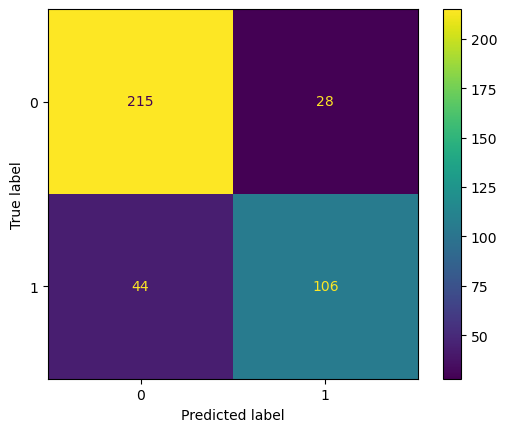

In [ ]:
cm = confusion_matrix(y_test, yhat)
cm_display = ConfusionMatrixDisplay(cm).plot()

### Feature Importance <a class="anchor" id="gb_feature_importance"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

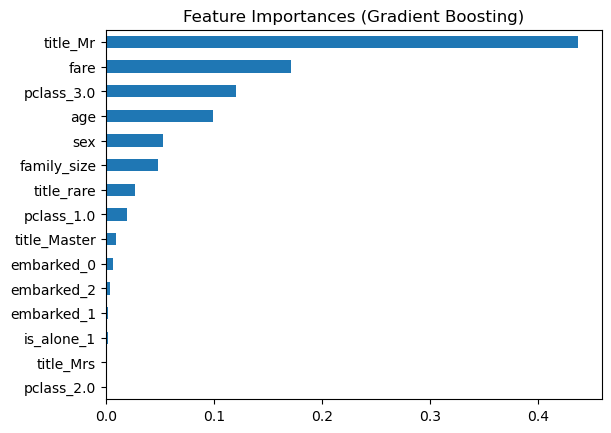

In [ ]:
# feature importances
importances = pd.Series(
    gb.feature_importances_, index=X_preproc.columns
).sort_values(ascending=True).plot.barh()
plt.title('Feature Importances (Gradient Boosting)')
plt.show()

### AdaBoost <a class="anchor" id="AdaBoost"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
# Build the AdaBoost model
ada = AdaBoostClassifier(algorithm="SAMME", random_state=117)

ab_train_start_time = time.time()

ada.fit(X_preproc, y_train)

ab_train_end_time = time.time()

print("Training time:", round(ab_train_end_time - ab_train_start_time, 4), "secs")

print(f"Train accuracy: {ada.score(X_preproc, y_train):.3f}")
print(f"Test accuracy: {ada.score(X_test_preproc, y_test):.3f}")

Training time: 0.049 secs
Train accuracy: 0.812
Test accuracy: 0.812


### Metrics <a class="anchor" id="AB_metrics"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

### Classification Report <a class="anchor" id="AB_classification_report"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

In [ ]:
ab_test_start_time = time.time()

yhat = ada.predict(X_test_preproc)

ab_test_end_time = time.time()

print("Testing time:", round(ab_test_end_time - ab_test_start_time, 4), "secs\n\n")

print(classification_report(y_test, yhat))

Testing time: 0.0072 secs


              precision    recall  f1-score   support

           0       0.86      0.83      0.85       243
           1       0.74      0.78      0.76       150

    accuracy                           0.81       393
   macro avg       0.80      0.81      0.80       393
weighted avg       0.81      0.81      0.81       393



### Confusion Matrix <a class="anchor" id="AB_confusion_matrix"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

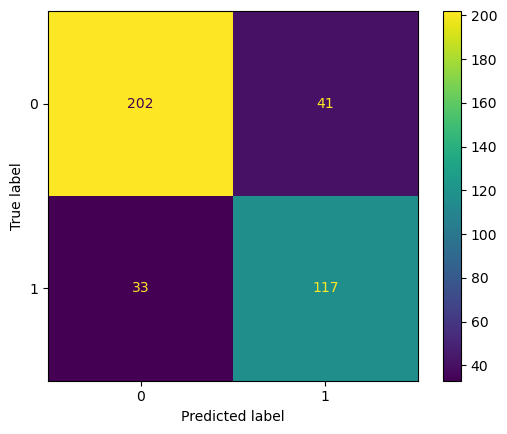

In [ ]:
cm = confusion_matrix(y_test, yhat)
cm_display = ConfusionMatrixDisplay(cm).plot()

### Feature Importance <a class="anchor" id="AB_feature_importance"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

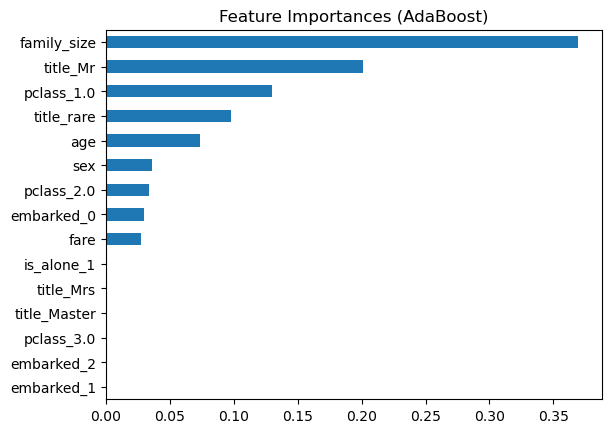

In [ ]:
# feature importances
importances = pd.Series(
    ada.feature_importances_, index=X_preproc.columns
).sort_values(ascending=True).plot.barh()
plt.title('Feature Importances (AdaBoost)')
plt.show()

## Models Comparison <a class="anchor" id="models_comparison"></a> <p style="text-align: right; color: blue; font-size: 15px"> [Go to Main Menu](#toc) </p>

<table style="height: 475px; width: 1087.5px;">
<tbody>
<tr>
<td style="width: 117px; text-align: center;"><strong>Algorithm</strong></td>
<td style="width: 197px; text-align: center;"><strong>Metrics</strong></td>
<td style="width: 376px; text-align: center;"><strong>Classification Report</strong></td>
<td style="width: 289.5px; text-align: center;"><strong>Confusion Matrix</strong></td>
</tr>
<tr>
<td style="width: 117px;"><strong>Decision Tree without pruning</strong></td>
<td style="width: 197px;">&nbsp;
<pre>Testing time: 0.0017 secs</pre>
<pre>Train accuracy: 0.977 <br />Test accuracy: 0.789</pre>
</td>
<td style="width: 376px;">

![dt_cr](dt_cr.png)

</td>
<td style="width: 289.5px;">

![dt_cm](dt_cm.png)
    
</td>
</tr>
<tr>
<td style="width: 117px;"><strong>Decision Tree with pruning</strong></td>
<td style="width: 197px;">
<pre>Training time: 0.006 secs</pre>
<pre>Testing time: 0.0011 secs<br /><br /></pre>
<pre>Train accuracy: 0.807 <br />Test accuracy: 0.807</pre>
&nbsp;</td>
<td style="width: 376px;">
    
![dtp_cr](dtp_cr.png)
    
</td>
<td style="width: 289.5px;">

![dtp_cm](dtp_cm.png)
    
</td>
</tr>
<tr>
<td style="width: 117px;"><strong>Random Forest</strong></td>
<td style="width: 197px;">&nbsp;
<pre>Training time: 0.1135 secs</pre>
<pre>Testing time: 0.0127 secs</pre>
<pre>Train accuracy: 0.977 <br />Test accuracy: 0.779</pre>
</td>
<td style="width: 376px;">

![rf_cr](rf_cr.png)

</td>
<td style="width: 289.5px;">
    
![rf_cm](rf_cm.png)    
    
</td>
</tr>
<tr>
<td style="width: 117px;"><strong>Gradient Boosted</strong></td>
<td style="width: 197px;">&nbsp;
<pre>Training time: 0.1109 secs</pre>
<pre>Testing time: 0.0025 secs</pre>
<pre>Train accuracy: 0.873
Test accuracy: 0.817</pre>
</td>
<td style="width: 376px;">
    
![gb_cr](gb_cr.png)    
    
</td>
<td style="width: 289.5px;">
    
![gb_cm](gb_cm.png)    
    
</td>
</tr>
<tr>
<td style="width: 117px;"><strong>Adaboost</strong></td>
<td style="width: 197px;">&nbsp;
<pre>Training time: 0.082 secs</pre>
<pre>Testing time: 0.012 secs</pre>
<pre>Train accuracy: 0.812
Test accuracy: 0.812</pre>
</td>
<td style="width: 376px;">

![adaboost_cr](adaboost_cr.png)

</td>
<td style="width: 289.5px;">

![adaboost_cm](adaboost_cm.png)
    
</td>
</tr>
</tbody>
</table>

## Summary
- Random forest shows the highest accuracy but with less testing accuracy, an indication of overfit.
- Adaboost metrics shows the balanced training and testing accuracy with least execution(training and testing) time.
- Gradient boost has the highest testing accuracy.

## Future Work:
- The Hyper parameters can be tuned for random forest, Adaboost and Gradient boost algorithms.
- Further Feature engineering can be performed to enhance the performance of the algorithms.